# 1. Build your own convolutional neural network using pytorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UsualCNN(nn.Module):
    def __init__(self):
        super(UsualCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1 * 1, 512) 
        self.fc2 = nn.Linear(512, 3) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(-1, 1024 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the network
net = UsualCNN()

# Print the network architecture
print(net)


UsualCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [13]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset for test images without class folders
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# Load datasets
train_dataset = datasets.ImageFolder('C:/Users/mahar/Downloads/Dog_heart/Dog_heart/Train', transform=train_transforms)
val_dataset = datasets.ImageFolder('C:/Users/mahar/Downloads/Dog_heart/Dog_heart/Valid', transform=val_transforms)

# Load the test dataset
test_dataset = CustomTestDataset(
    root_dir='C:/Users/mahar/Downloads/Test/Test',
    transform=test_transforms
)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model, loss function, and optimizer
model = UsualCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 45
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Train model
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation 
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the model if the validation loss decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'UsualCnn_model.pth')
        print(f'Saving model with validation loss {val_loss:.4f}')



Epoch [1/45], Train Loss: 1.0137, Val Loss: 1.0029
Saving model with validation loss 1.0029
Epoch [2/45], Train Loss: 1.0078, Val Loss: 0.9847
Saving model with validation loss 0.9847
Epoch [3/45], Train Loss: 0.9958, Val Loss: 0.9888
Epoch [4/45], Train Loss: 0.9872, Val Loss: 0.9677
Saving model with validation loss 0.9677
Epoch [5/45], Train Loss: 0.9724, Val Loss: 0.9379
Saving model with validation loss 0.9379
Epoch [6/45], Train Loss: 0.9385, Val Loss: 1.0712
Epoch [7/45], Train Loss: 0.9622, Val Loss: 0.8814
Saving model with validation loss 0.8814
Epoch [8/45], Train Loss: 0.9343, Val Loss: 0.8053
Saving model with validation loss 0.8053
Epoch [9/45], Train Loss: 0.8985, Val Loss: 0.8878
Epoch [10/45], Train Loss: 0.8946, Val Loss: 0.7427
Saving model with validation loss 0.7427
Epoch [11/45], Train Loss: 0.8724, Val Loss: 0.7416
Saving model with validation loss 0.7416
Epoch [12/45], Train Loss: 0.8684, Val Loss: 0.7360
Saving model with validation loss 0.7360
Epoch [13/45], T

# 3. Evaluate your model using the developed software

In [16]:
import pandas as pd

model.load_state_dict(torch.load('C:/Users/mahar/UsualCnn_model.pth'))
model.eval()

test_predictions = []
image_paths = []
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

# Predictions to save in a CSV file
def save_predictions_to_csv(predictions, filenames, filename):
    filenames = [os.path.basename(path) for path in filenames]
    df = pd.DataFrame(list(zip(filenames, predictions)))
    df.to_csv(filename, index=False, header=False)

save_predictions_to_csv(test_predictions, image_paths, 'UsualCnn_test_predictions.csv')

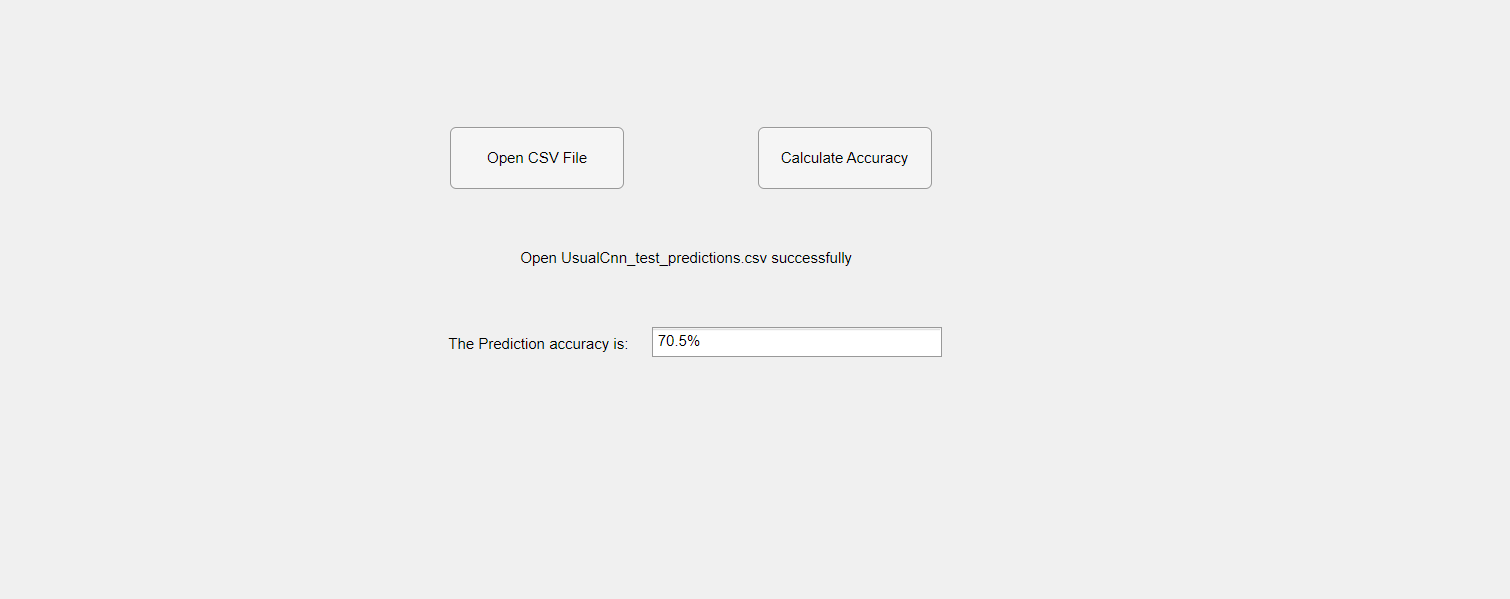

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 70%

The model was determined to be 70.5% accurate by the results obtained. These are the same performances as those reported in (RVTpaper) where a 70% accuracy is presented and VGG16 model were used. Thus, it can be said that the model performance is equivalent with VGG16 as mentioned in RVT paper.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

ResearchGate Link: https://www.researchgate.net/publication/382111904_UsualCNN_A_Custom_Convolutional_Neural_Network_for_Image_Classification

Github Link: https://github.com/Prudhvi890/UsualCNN-Weights

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 70 % -->10 points
     < 50 % -->0 points
     >= 50 % & < 70% --> 0.5 point/percent
     

(6). Discussion - 10 points